# scGraphDiffusion

In [1]:
# Loading Packages
import info_log
info_log.print('\n> Loading Packages')
import torch
from time import time

# Local modules
import load
import preprocess
from auto_encoders.graph_DIF import graph_diffusion
from clustering import kmeans, louvain, leiden, record_cluster, clustering

from scdata_metrics import SCData
from scdata_visualization import umap_view, trajectory_view, similarity_view, diffusion_view, clustering_comparation_view, gnd_view
from scdata_exporting import export_data
from build_graph import build_graph, build_gnd_graph
from modify_graph import modify_graph
from call_attention import call_attention, call_gnd_attention
from call_modularity import call_modularity, call_gnd_modularity, view_gnd_modularity
from build_trajectory import build_trajectory
from umap_embedding import umap_embedding, special_umap_embedding, diffusion_umap_embedding, diffusion_ML_embedding

2023-10-10 21:16:19,209 - 
> Loading Packages
2023-10-10 21:17:05.713210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 21:17:16.028067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
print(torch.cuda.get_device_name())

cuda
Tesla V100-SXM2-16GB


In [3]:
DATA_PATH = 'data/traj_data_real/oligodendrocyte-differentiation-subclusters_marques'

OUTPUT_PATH = 'outputs/oligodendrocyte-differentiation-subclusters_marques/'


## Loading data and preprocessing 

Load counts matrix

In [4]:
import pandas as pd

# Read the CSV file
counts = pd.read_csv(DATA_PATH+"_count.csv",index_col=0)

import numpy as np
genes = np.array(counts.columns)
cells = np.array(counts.index)
counts_np = np.array(counts)

print(counts_np.shape)


(4930, 3534)


Load cluster labels

In [5]:
cluster_labels = pd.read_csv(DATA_PATH+"_clusters.csv",index_col=0)

cluster_np = np.squeeze(np.array(cluster_labels))

cluster_unq = np.unique(cluster_np)
n = 0
for it in cluster_unq:
    cluster_np[cluster_np==it] = n
    n+=1
cluster_np_unq = np.unique(cluster_np)

print(cluster_unq)
print(cluster_np_unq)

['COP' 'MFOL1' 'MFOL2' 'MOL1' 'MOL2' 'MOL3' 'MOL4' 'MOL5' 'MOL6' 'NFOL1'
 'NFOL2' 'OPC']
[0 1 2 3 4 5 6 7 8 9 10 11]


Load trajectory indormation

In [6]:
traj_info = pd.read_csv(DATA_PATH+"_traj.csv",index_col=0)
print(traj_info)

     from     to  length  directed
1     OPC    COP       1      True
2     COP  NFOL1       1      True
3   NFOL1  NFOL2       1      True
4   NFOL2  MFOL1       1      True
5   MFOL1  MFOL2       1      True
6   MFOL2   MOL1       1      True
7   MFOL2   MOL2       1      True
8   MFOL2   MOL3       1      True
9   MFOL2   MOL4       1      True
10  MFOL2   MOL5       1      True
11  MFOL2   MOL6       1      True


In [7]:
traj_info_np = traj_info[['from','to']].replace(to_replace=cluster_unq, value=cluster_np_unq)
#traj_info_np = traj_info['to'].replace(to_replace=cluster_unq, value=cluster_np_unq)
print(traj_info_np)

traj_array = np.array(traj_info_np).T

traj_edge_list=[]
for i in range(len(traj_array[0])):
    traj_edge_list.append((traj_array[0][i], traj_array[1][i], 1)) 


print(traj_edge_list)


    from  to
1     11   0
2      0   9
3      9  10
4     10   1
5      1   2
6      2   3
7      2   4
8      2   5
9      2   6
10     2   7
11     2   8
[(11, 0, 1), (0, 9, 1), (9, 10, 1), (10, 1, 1), (1, 2, 1), (2, 3, 1), (2, 4, 1), (2, 5, 1), (2, 6, 1), (2, 7, 1), (2, 8, 1)]


In [8]:
scdata = SCData(expression=counts_np, cell=cells, gene=genes)
scdata.cluster = cluster_np


2023-09-28 12:07:56,161 - 
> Preprocessing data ...
2023-09-28 12:07:56,162 - ---------> Log-transforming data ...
2023-09-28 12:07:56,511 - ---------> Sorting and selecting top genes ...


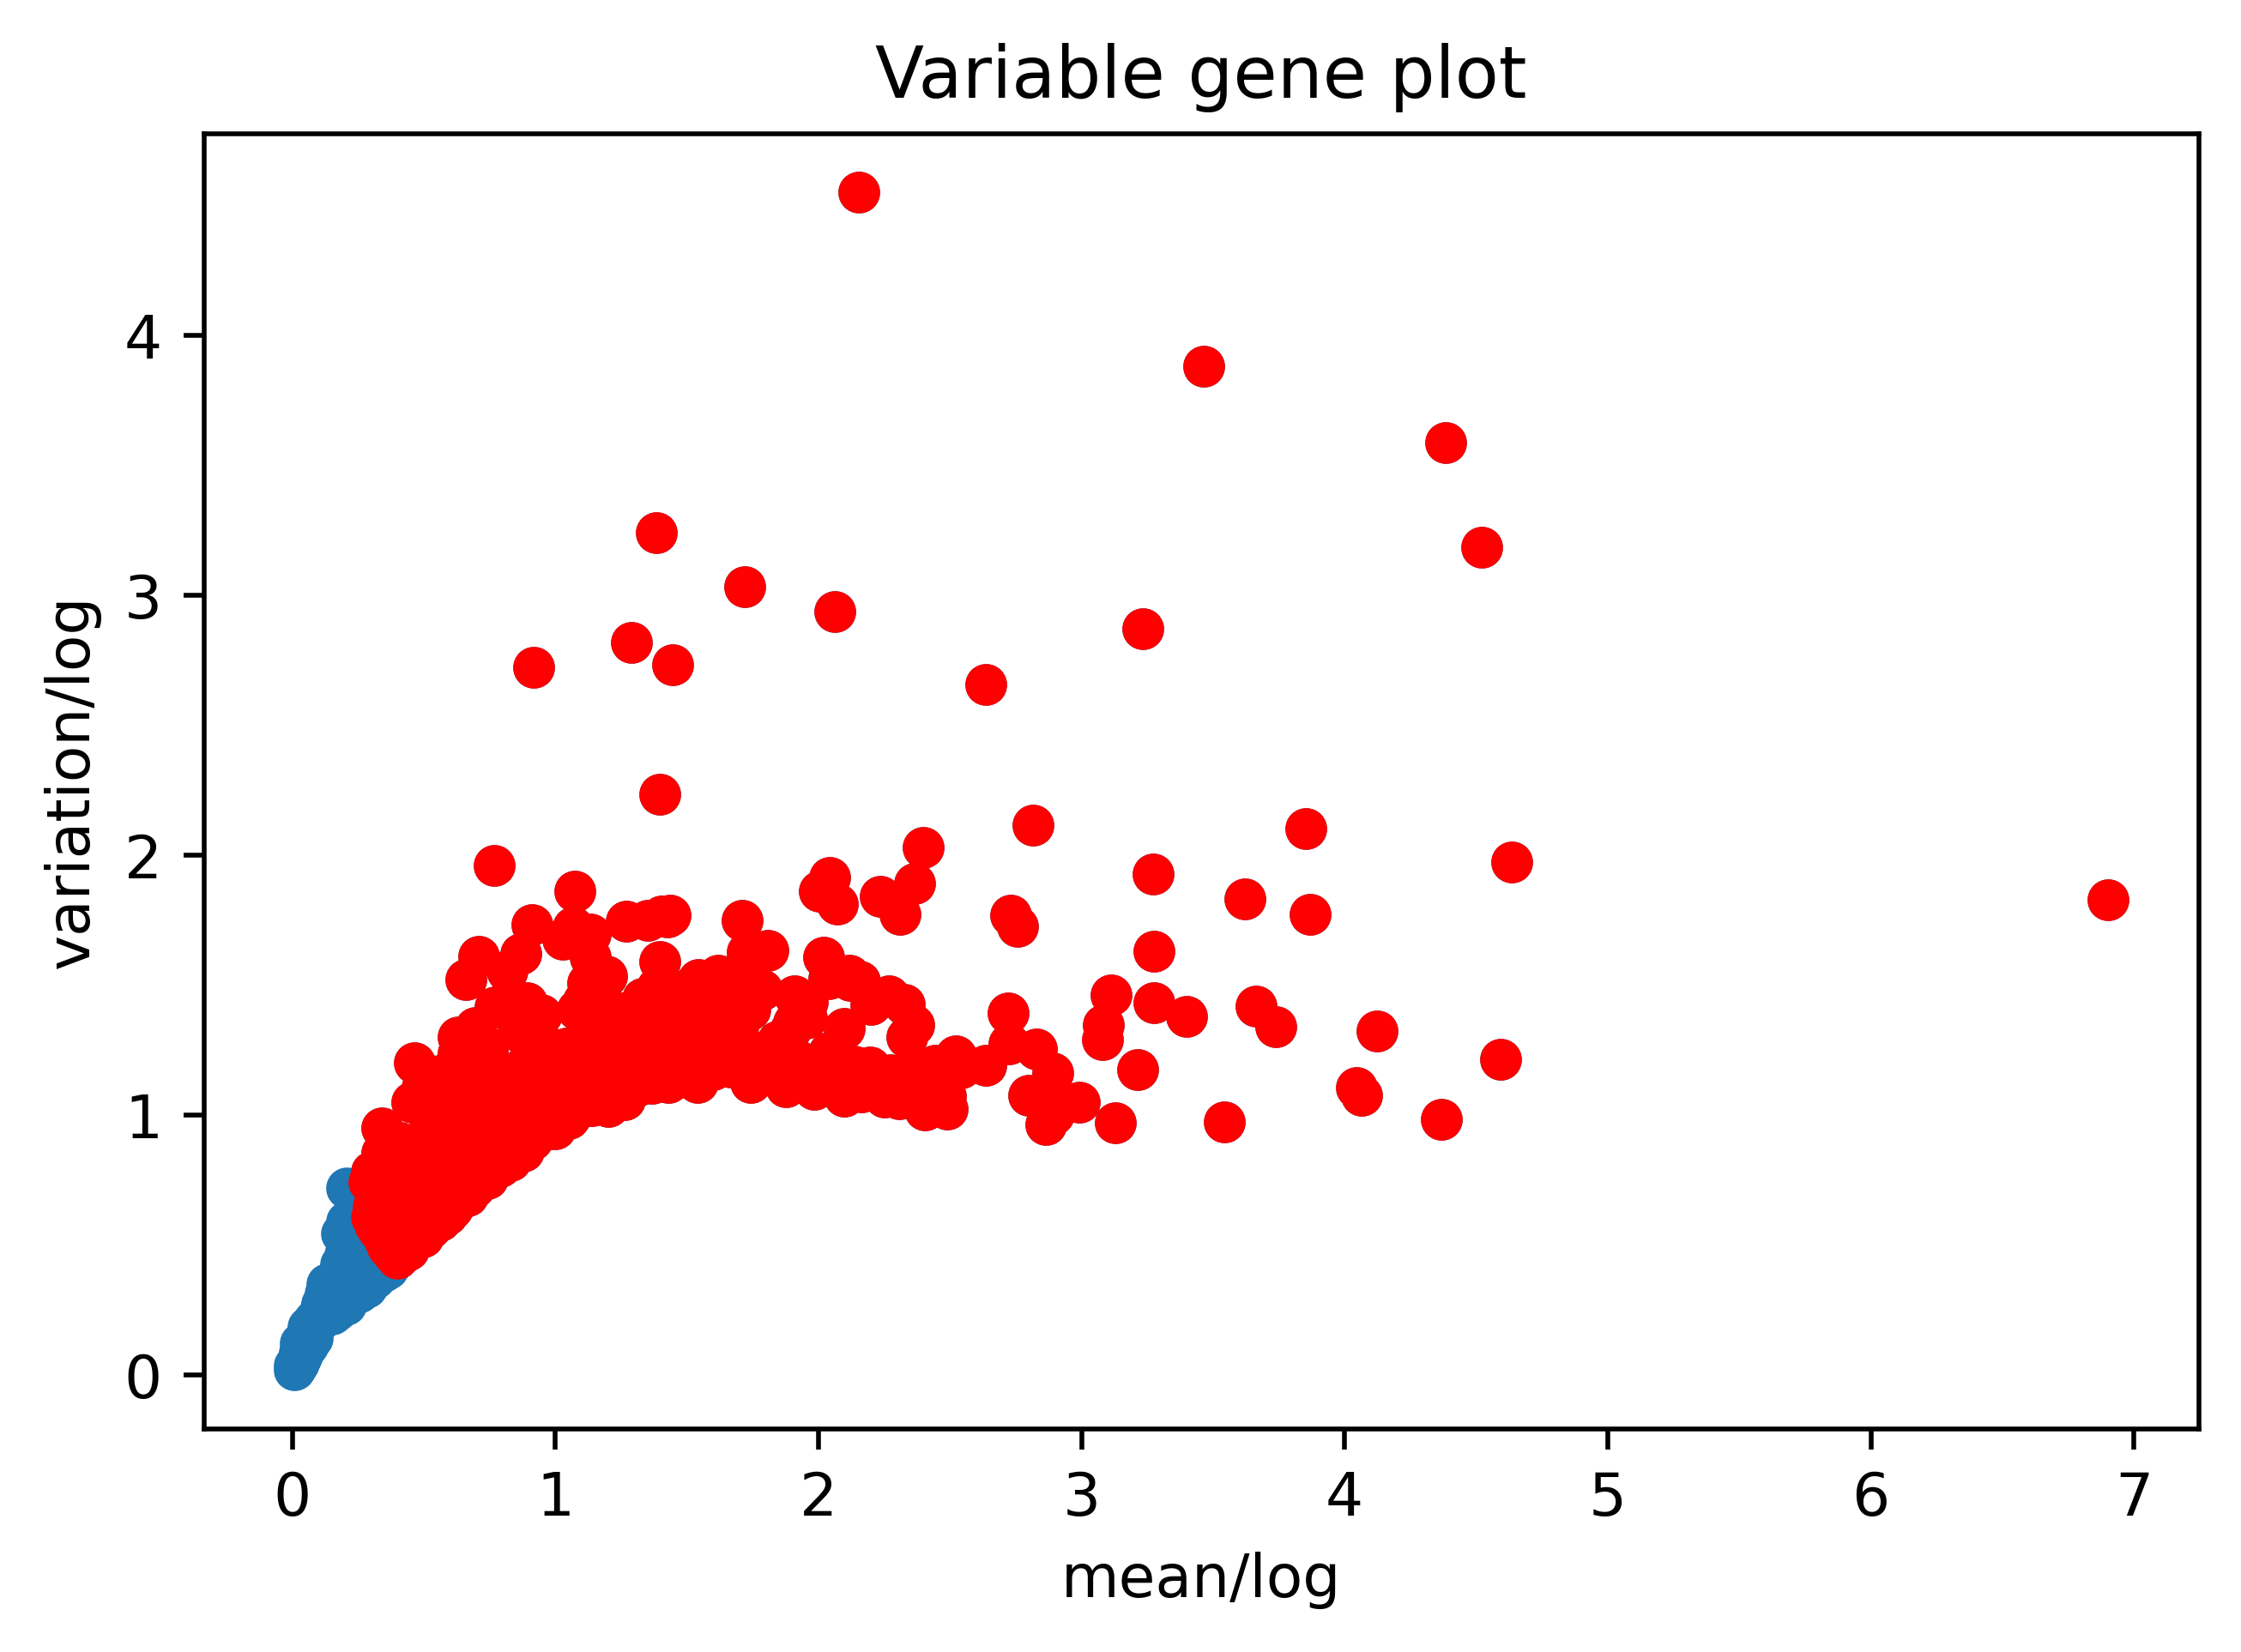

(4930, 2000)


In [96]:
# Preprocessing(pp)
info_log.print('\n> Preprocessing data ...')

# pp method 1
#scdata = preprocess.percentile_filter(scdata, cell_cutoff=0, gene_cutoff=10)

#scdata = preprocess.key_filter(scdata, gene_key=None, cell_key=None)

scdata = preprocess.log_transform(scdata, data_type = "raw", log=True, scale=True, scale_factor=10000)

scdata = preprocess.varibale_gene_select(scdata, data_type="raw.log", num_select=2000)

print(scdata.svg.expr.shape)

In [11]:
print(scdata.svg.expr.shape)

(4930, 2000)


## Diffusion process

In [58]:
# Build graph

scdata = build_graph(scdata, k=100, data_type="svg", graph_name='dif_graph', self_edge = False, prune=True)

print(scdata.dif_graph.edge_index.size())


torch.Size([2, 477921])


In [59]:
scdata = graph_diffusion(scdata, D_out=2000, data_type='svg', use_graph='dif_graph', recover_adj_name='dif_graph',
                      max_epoch=2000, lr=5e-4, device=device,
                           num_features_diffusion=50,
                           num_heads_diffusion=6,
                           num_steps_diffusion=8, 
                           time_increment_diffusion=0.2,
                           attention_type = 'sum', 
                           activation=torch.nn.ELU(),
                           dropout=0.0, 
                           log_attention=False, 
                           log_diffusion=True,
                           encoder=[300], 
                           decoder=[300],
                           save_model = True,
                           load_model_state = False,
                           loss_adj=0.2,
                           rebuild_graph=False,
                           k=5)
scdata.save(OUTPUT_PATH+"scdata.pickle")


2023-09-28 11:20:38,454 - --------> Starting Graph AE ...
/projectnb/czproj/Algorithms/ycliu/scGraphDiffusion/auto_encoders/graph_DIF.py:143: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(adj_graph.adj.to(device), dtype = recon_adj.dtype)
/projectnb/czproj/Algorithms/ycliu/scGraphDiffusion/auto_encoders/graph_DIF.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_2 = torch.tensor(feature_matrix.to(device), dtype = out_nodes_features.dtype)
2023-09-28 11:20:51,138 - ------------------------> Epoch: 1/2000, Current loss: 3218741504.0000
2023-09-28 11:20:59,416 - ------------------------> Epoch: 51/2000, Current loss: 17559504.0000
2023-09-28 11:21:07,709 -

In [9]:
scdata = SCData.load(OUTPUT_PATH+"scdata_gae.pickle")

## Check scdata

In [122]:
# scdata.print_data()

## View UMAP of diffusion data

In [10]:
# Rebuild graph
scdata = build_graph(scdata, k=10, data_type="gae", graph_name='graph', self_edge = False, prune=True)


In [11]:
scdata = umap_embedding(scdata, data = 'gae.output', umap_args = {'n_neighbors': 150,
                                'min_dist': 0.1,
                                'metric': 'correlation',
                                'random_state': 2021})
scdata = umap_embedding(scdata, data = 'gae.input', umap_args = {'n_neighbors': 150,
                                'min_dist': 0.1,
                                'metric': 'correlation',
                                'random_state': 2021})

/share/pkg.7/python3/3.9.9/install/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


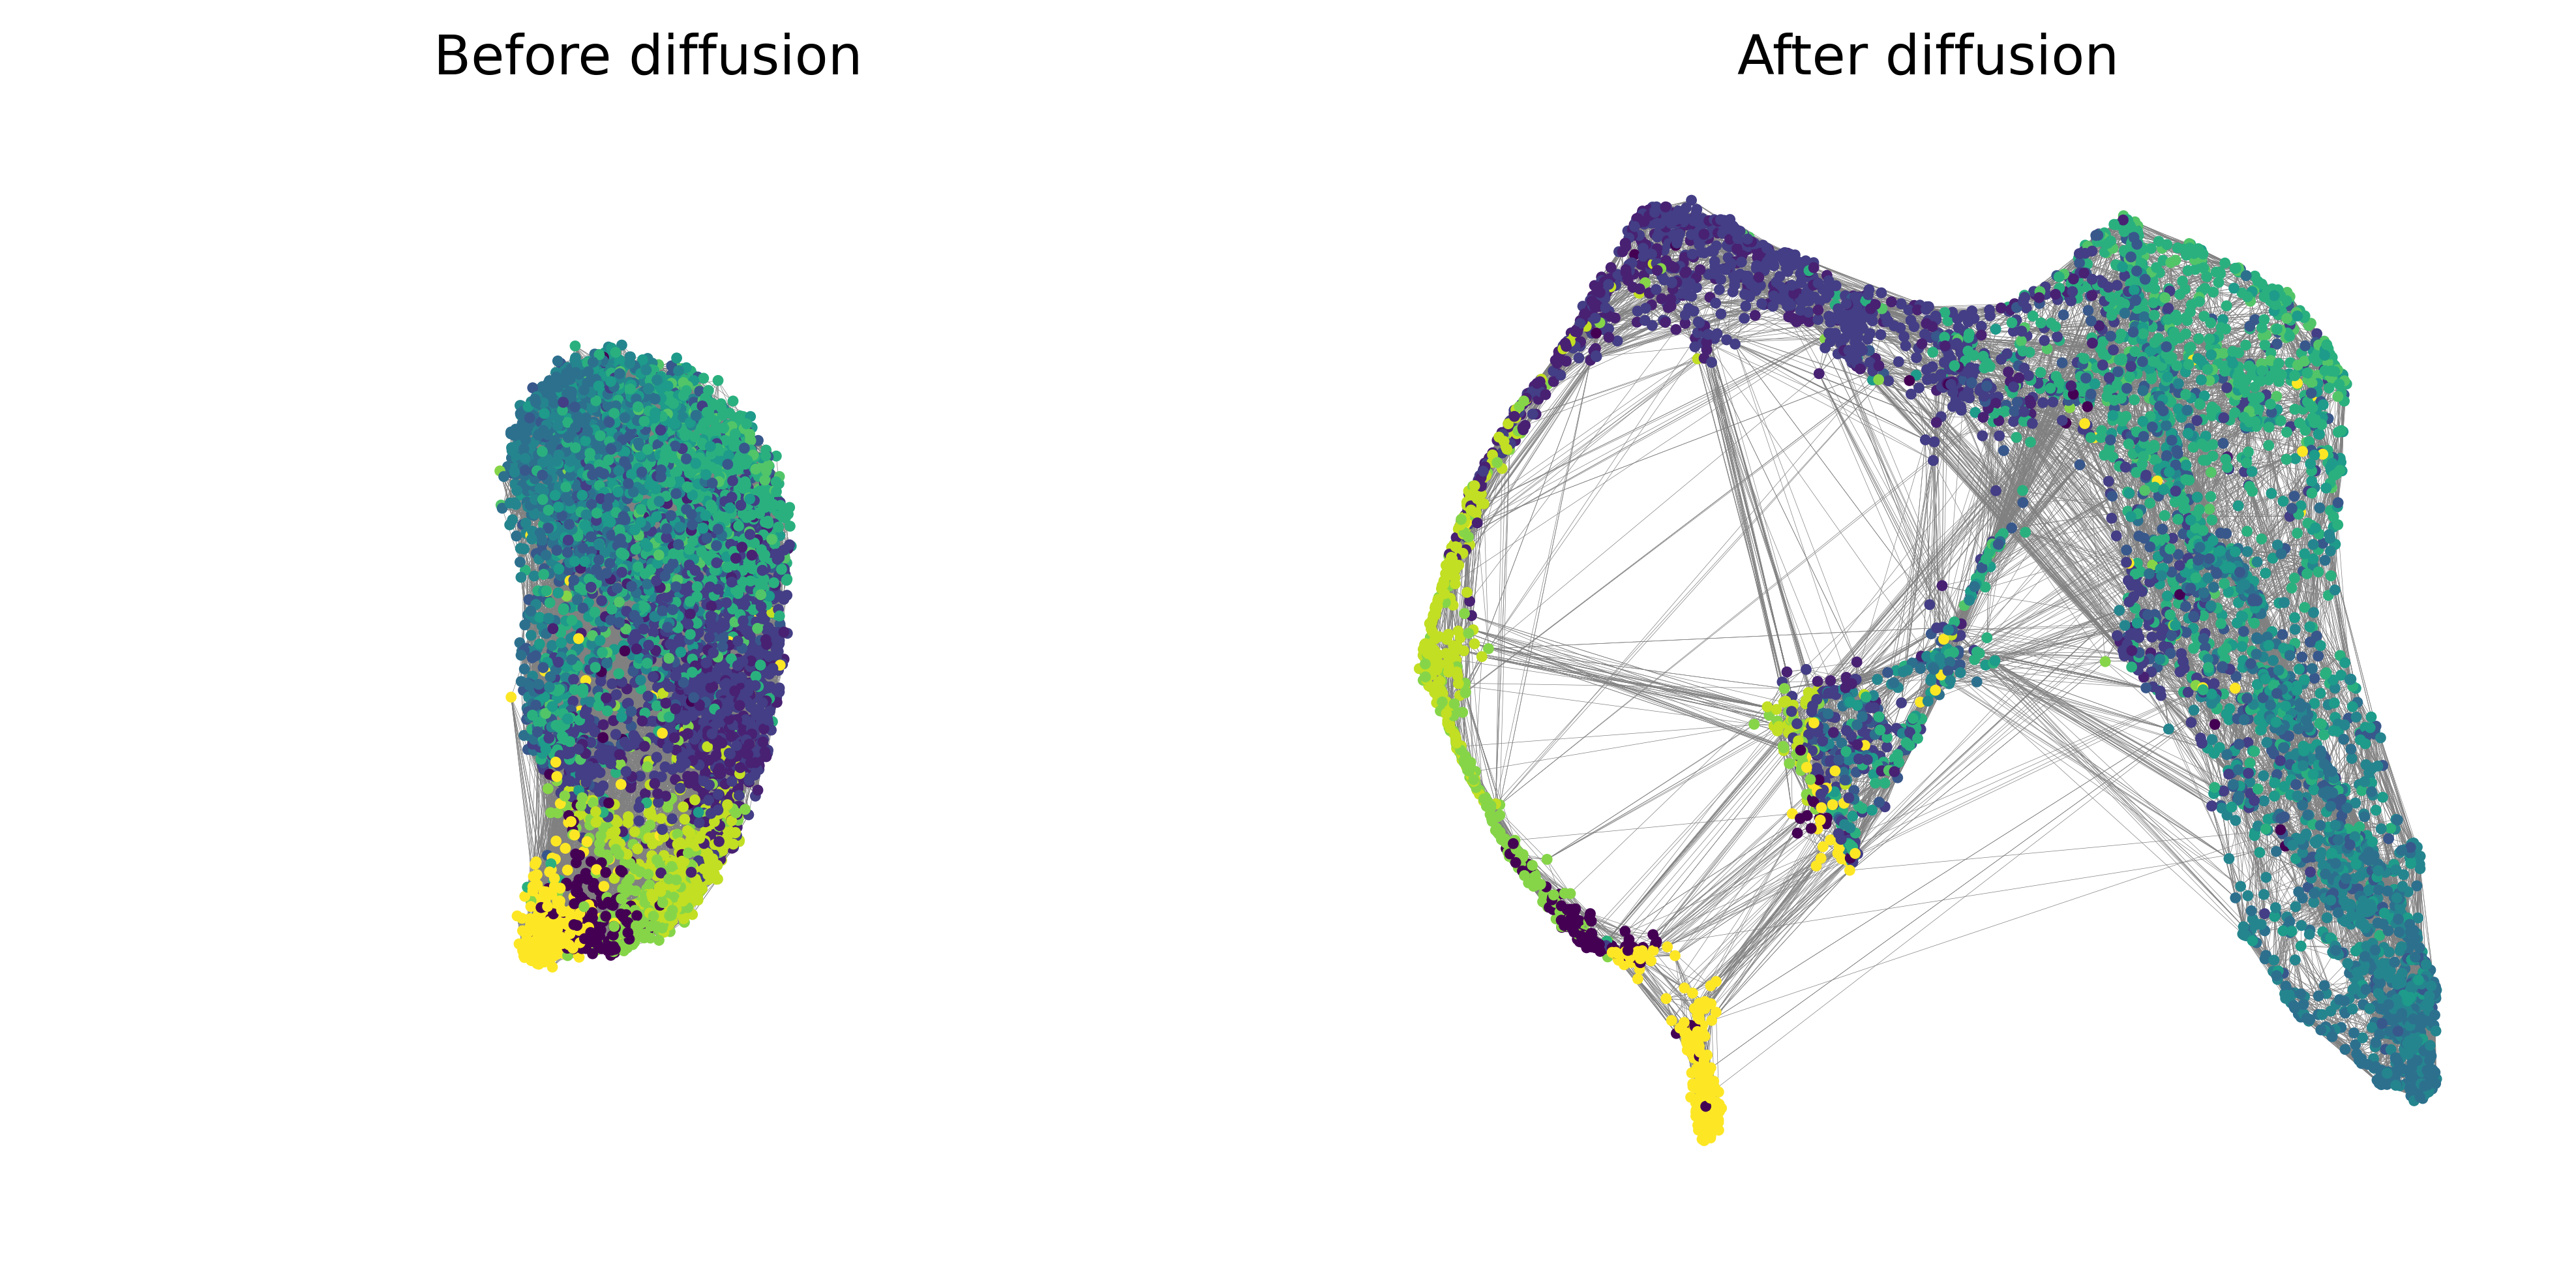

In [12]:
gnd_view(scdata, fig_size = (8,4), 
                   clusters=True, edges=True, 
                   edge_scale=0.1, node_scale=2, save_fig=None)

# umap_view(scdata, data='gae.output',clusters=False, edges=True, 
#           edge_scale=0.02, node_scale=0.5, save_fig=OUTPUT_PATH+'umap.png')

## Call cell-cell attentions

### Attention for scdata.graph

In [13]:
# build acdata.graph

scdata = build_graph(scdata, k=30, data_type="gae", graph_name='graph', self_edge = False, prune=True)

print("Total number of edges: ", scdata.graph.edge_index.shape[1])


Total number of edges:  147071


In [15]:
# Calculation attentions

scdata = call_attention(scdata, data_type="gae_output", use_graph="graph", distance_adjust=False)


In [16]:
#load attentions to edges of acdata.graph

scdata.graph.load_edge_attention(attention_type='adjusted_attention')


## Save scdata

In [17]:

scdata.save(OUTPUT_PATH+"scdata.pickle")


## Load scdata

In [10]:
scdata = SCData.load(OUTPUT_PATH+"scdata.pickle")

## Build trajectory

In [25]:
# Build trajectory

scdata = build_trajectory(scdata, use_graph="graph", use_attention=True, 
                                                      regulate_cell=True, 
                          similarity_adjust=False, trg_adjust=True, use_around_community=False, 
                          around_community=1.0, tune_pos=0.5, tune_pos_scale=1.1, origin_cluster=11, use_position=False)

#scdata.save(OUTPUT_PATH+"scdate_traj_1.pickle")

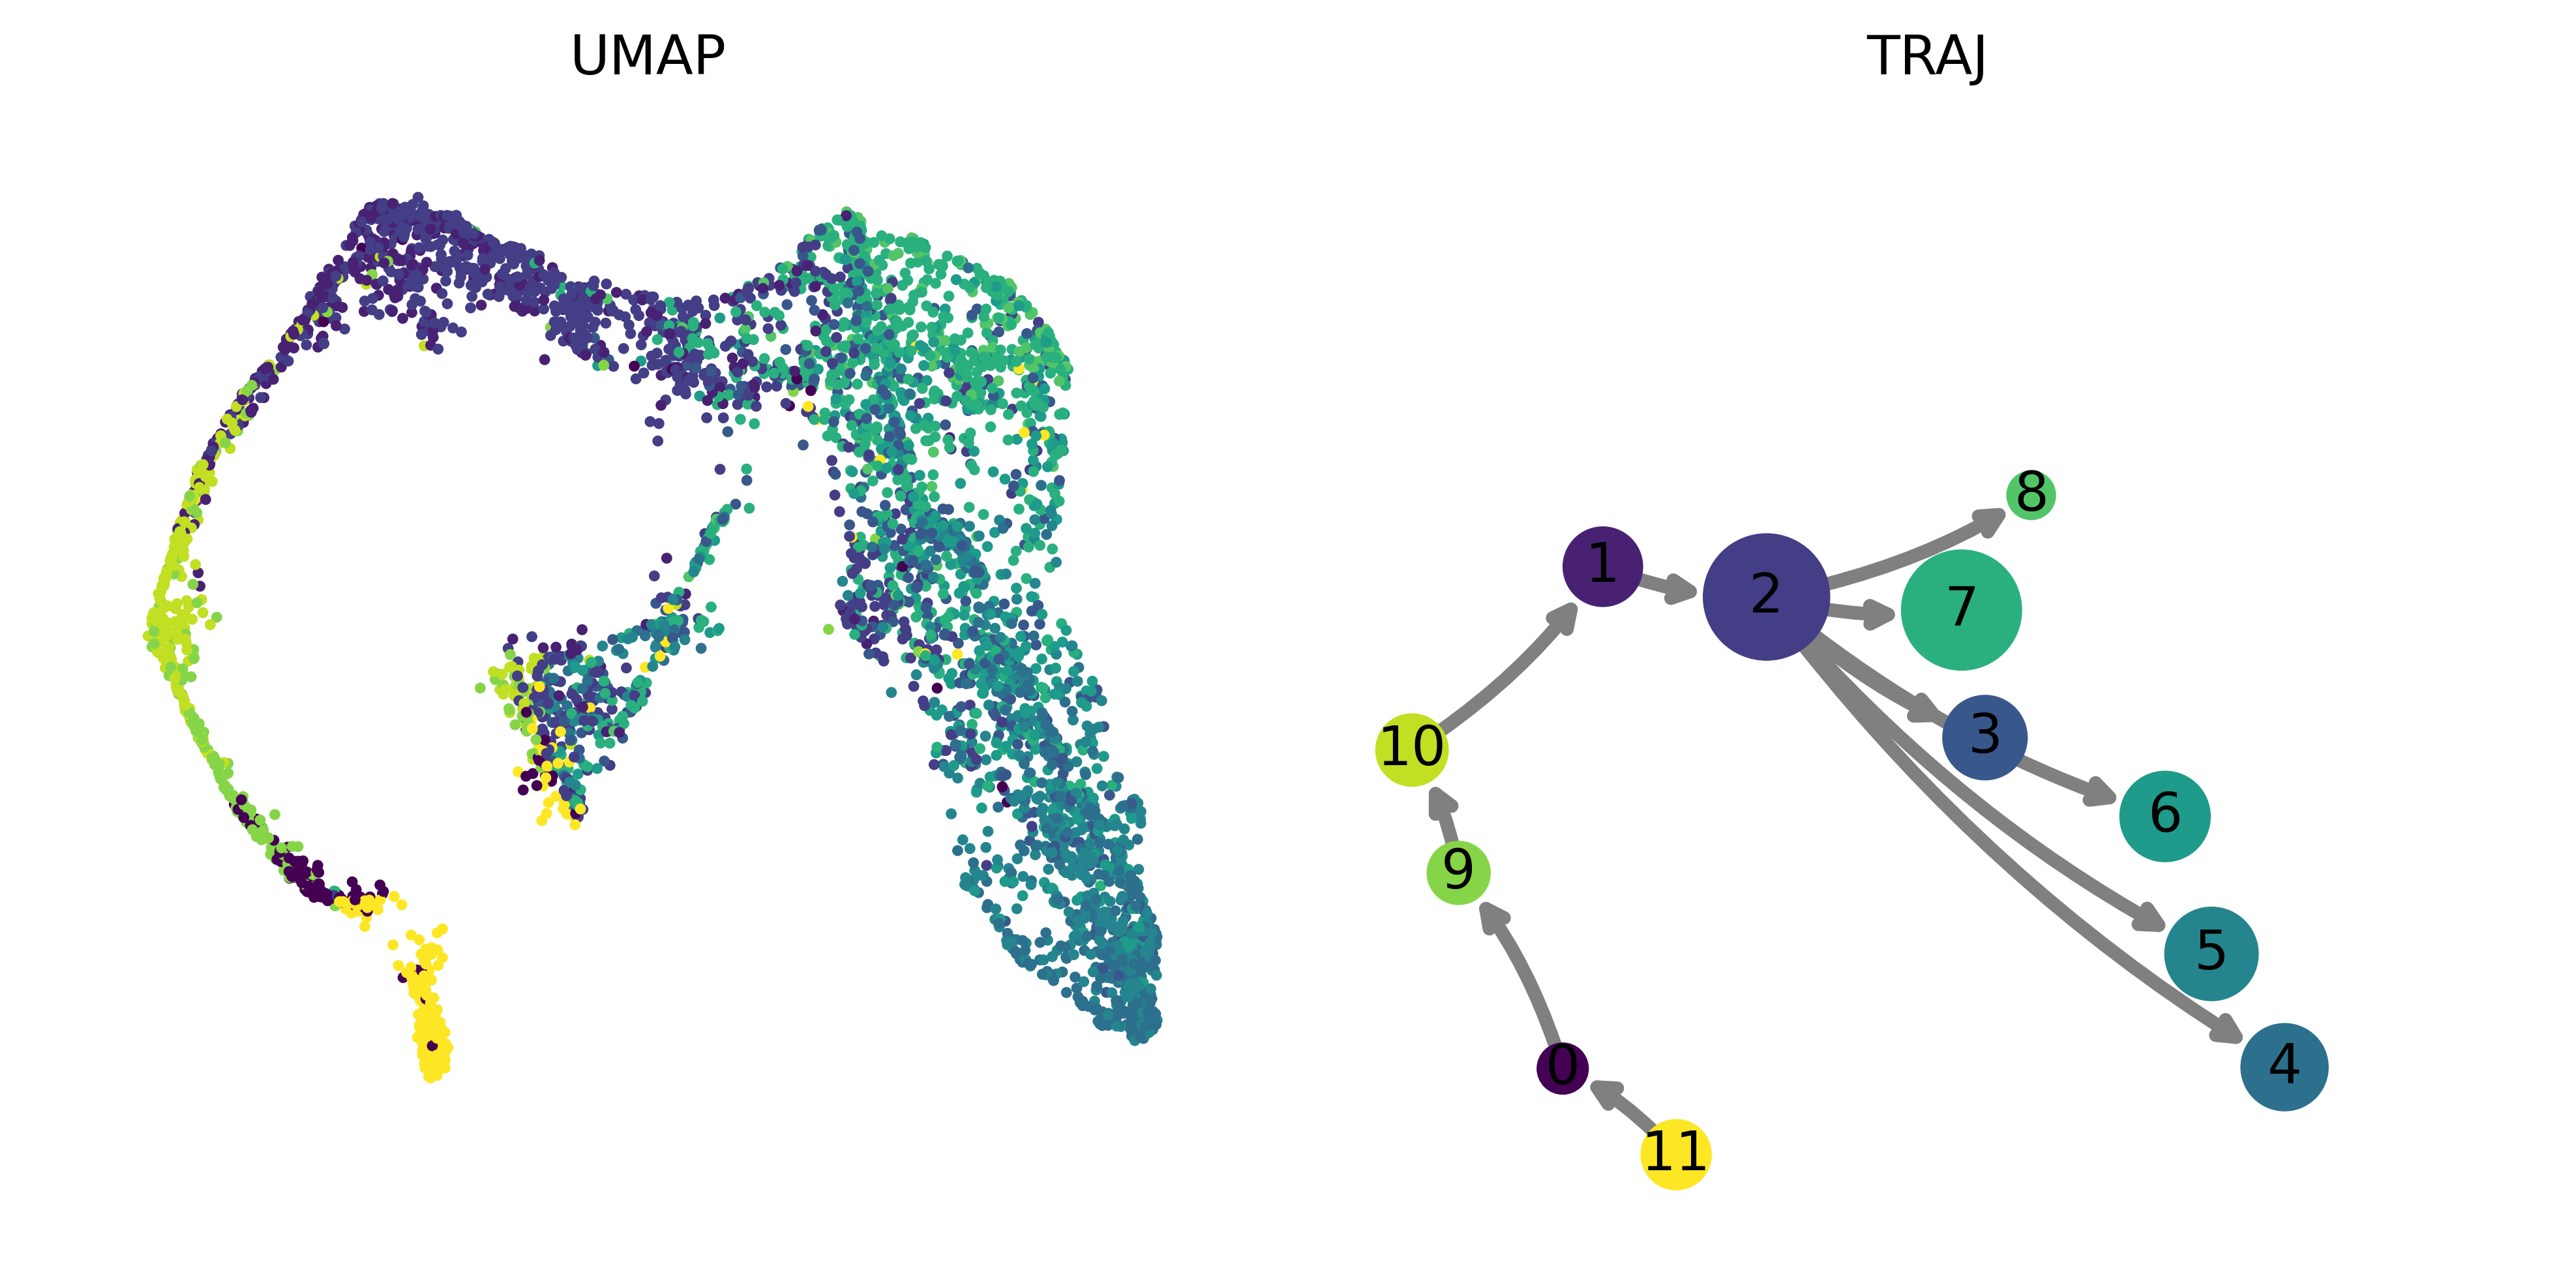

In [26]:
trajectory_view(scdata, use_traj=None, edge_threshold=0.0, edge_scale=3, node_scale=0.8, node_labels=True,
                    node_pos=True, show_umap=True, resolution=1.0, fig_size=(8,4),
                       umap_args={'edge_scale': 0.0,
                             'node_scale': 2},
                       save_fig=OUTPUT_PATH+'traj_scdif.png')

In [1]:
correct = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

score = len(correct)/11
print(11-len(correct))
print(score)

0
1.0


# Trajectory Reference

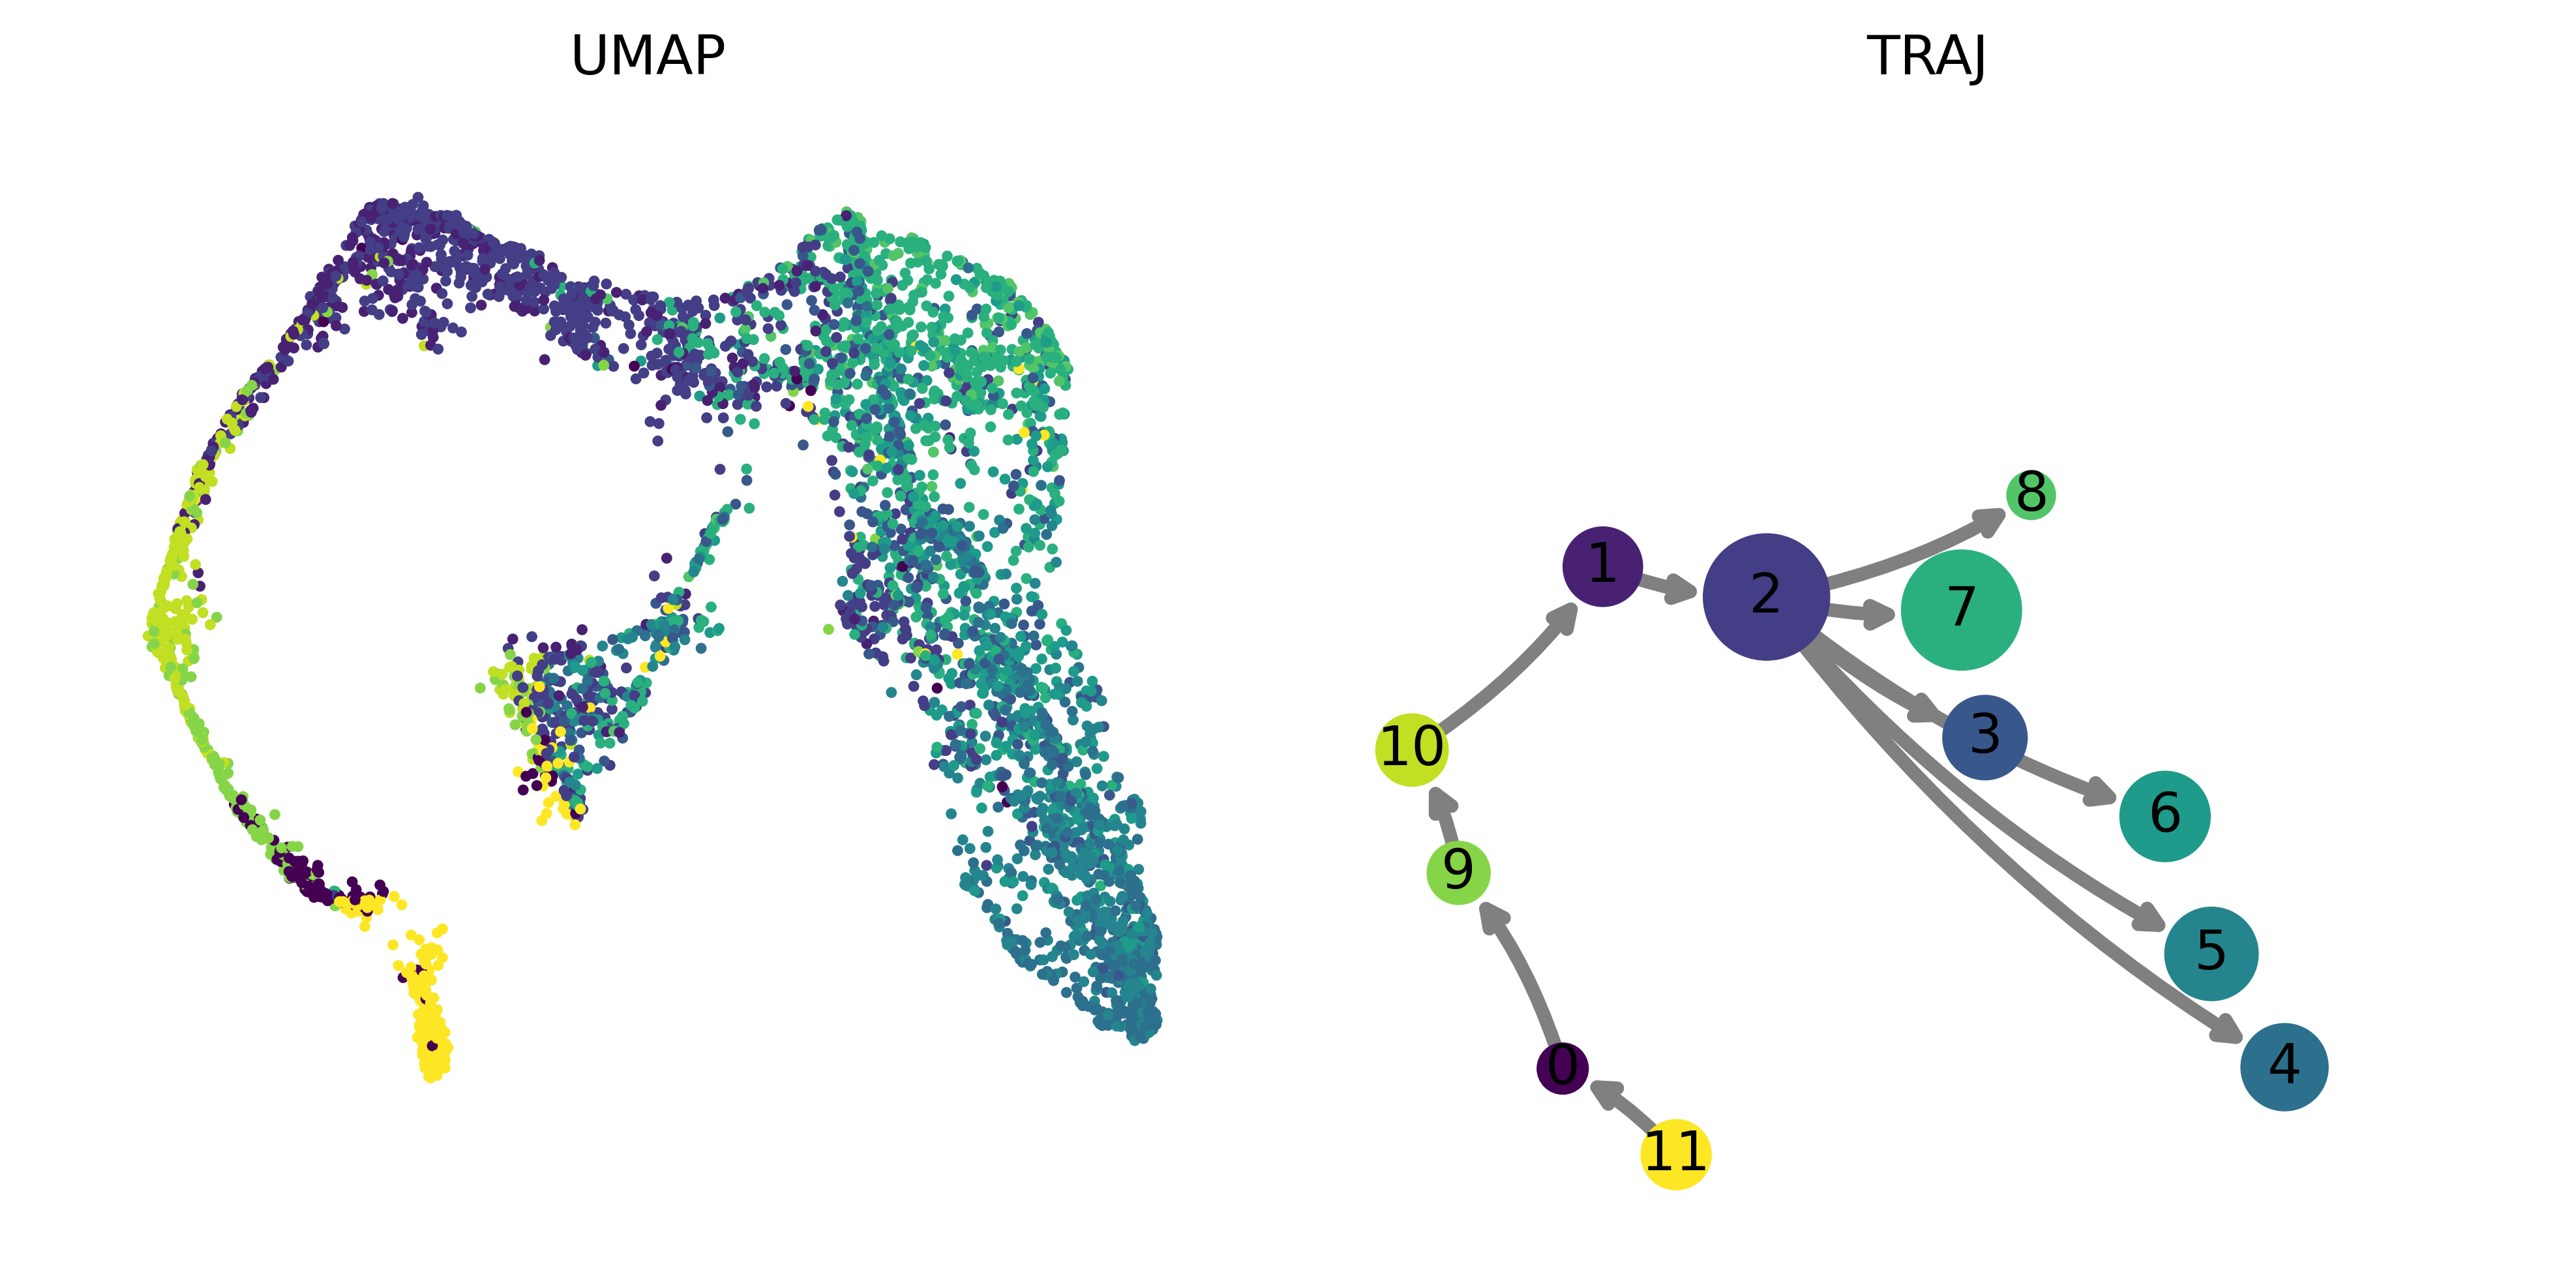

In [149]:
trajectory_view(scdata, use_traj=traj_edge_list, edge_threshold=0.4, edge_scale=3, node_scale=0.8, node_labels=True,
                       node_pos=True, show_umap=True, resolution=1.0, fig_size=(8,4),
                       umap_args={'edge_scale': 0.0,
                             'node_scale': 2},
                       save_fig=OUTPUT_PATH+'traj_reference.png')


# Save data

In [31]:
scdata.save(OUTPUT_PATH+"scdata_traj.pickle")

# Load data

In [ ]:
scdata = SCData.load(OUTPUT_PATH+"scdata_traj.pickle")